### Google drive mounting

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### imports

In [2]:
import pandas as pd
import numpy as np
# import cv2
# import matplotlib.pyplot as plt
import os
import psutil
# import tensorflow as tf
# from matplotlib.patches import Rectangle
# from google.colab.patches import cv2_imshow
# import json
import warnings
from PIL import Image
from io import BytesIO
warnings.filterwarnings(action='ignore')

In [ ]:
box_df = pd.read_parquet('drive/MyDrive/object_detection/data/camera1_box.parquet').drop_duplicates()
box_df = box_df.loc[box_df.type != 4]
box_df['type'] = box_df.type - 1
img_df = pd.read_parquet('drive/MyDrive/object_detection/data/waymo_camera_image/camera1_data_part1.parquet').drop_duplicates()
box_cols = ['segment', 'frame_timestamp','camera_object_id',
            'box_center_x', 'box_center_y', 'box_size_x', 'box_size_y', 'type']
img_cols = ['image']
df = box_df[box_cols].join(img_df[img_cols])
df = df.loc[df.image.notna()].drop_duplicates()

with BytesIO(df.iloc[0].image) as f:
    with Image.open(f) as img:
        # Get the size of the image in pixels
        WIDTH, HEIGHT = img.size

In [ ]:
# average frames per segment
df.groupby('segment').count().image.mean()

233.18800000000002

# see example annotations

vehicles: 28
people: 29 



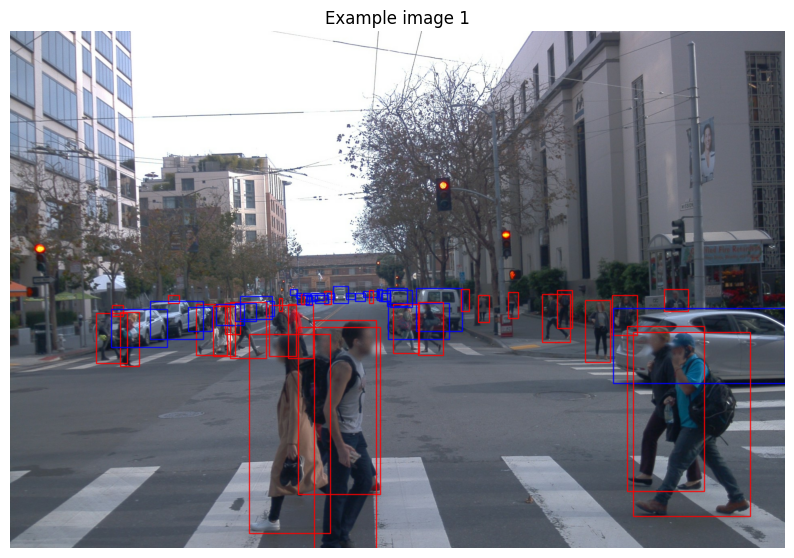

vehicles: 27
people: 1 



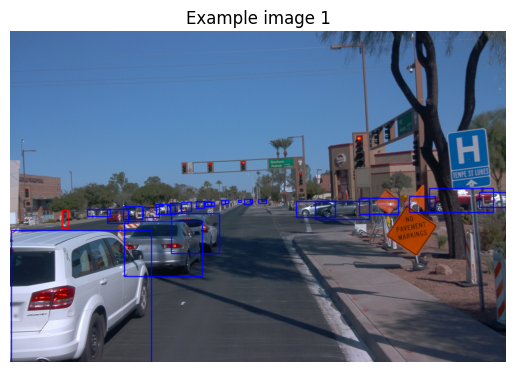

vehicles: 34
people: 1 



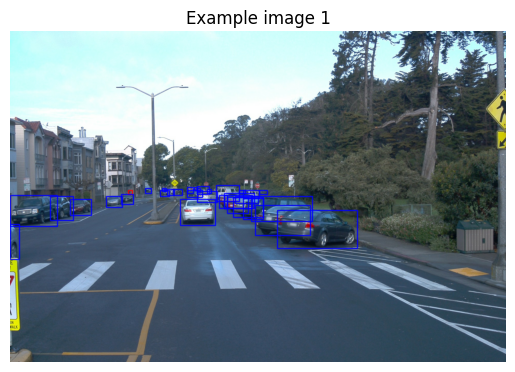

In [ ]:
c_map = {0:'b',1:'r'}
type_map = {1:'vehicle', 2:'person'}
def show_image(data, layout=None):
    """Display the given camera with box."""
    if layout:
        r,c,plot_index = layout
        ax = plt.subplot(r,c,plot_index+1)
    else: 
        ax = plt.subplot(1,1,1)
        plot_index=0
    plt.imshow(tf.image.decode_jpeg(data.image))
    this_frame = df.loc[data.name]
    if type(this_frame) == pd.Series: 
        this_frame = pd.DataFrame(this_frame).transpose()
    print("vehicles:",this_frame.loc[this_frame.type==1].shape[0])
    print("people:",this_frame.loc[this_frame.type==2].shape[0],'\n')
    for i in range(this_frame.shape[0]):
        this_data = this_frame.iloc[i]
        lower_left_x = this_data.box_center_x - (this_data.box_size_x // 2)
        lower_left_y = this_data.box_center_y - (this_data.box_size_y // 2)
        box = Rectangle((lower_left_x, lower_left_y), 
                                this_data.box_size_x, 
                                this_data.box_size_y)
        box.set(fill=False,edgecolor=c_map[this_data.type], alpha=0.8)
        ax.add_patch(box)
    plt.title(f'Example image {plot_index%2+1}')
    plt.grid(False)
    plt.axis('off')
    return ax

plt.figure(figsize=(10,10))

imgs = [df.sample(random_state=i).iloc[0] for i in range(3)]
show_image(imgs[0])
plt.show()
show_image(imgs[1])
plt.show()
show_image(imgs[2])
plt.show()

# Mobilenet SSD predictions

In [ ]:
imgs = [df.sample(random_state=i).iloc[0] for i in range(3)]
px_imgs = [np.array(tf.image.decode_jpeg(img.image)) for img in imgs]
# resize to match input size, convert to blob to pass into model
resized_imgs_to_detect = [cv2.resize(img,(300,300)) for img in px_imgs]
img_blob = cv2.dnn.blobFromImages(resized_imgs_to_detect,
                                    scalefactor=0.007843,
                                    size=(300,300),
                                    mean=127.5,
                                    swapRB=False)

# set of 21 class labels in alphabetical order (background + rest of 20 classes)
class_labels = ["background", "aeroplane", "bicycle", "bird", "boat","bottle", "bus", "car", "cat", "chair", "cow", "diningtable","dog", "horse", "motorbike", "person", "pottedplant", "sheep","sofa", "train", "tvmonitor"]

# Loading pretrained model from prototext and caffemodel files
# input preprocessed blob into model and pass through the model
# obtain the detection predictions by the model using forward() method
mobilenetssd = cv2.dnn.readNetFromCaffe(
    'drive/MyDrive/object_detection/pretrained_models/MobileNetSSD/mobilenetssd.prototext.txt',
    'drive/MyDrive/object_detection/pretrained_models/MobileNetSSD/MobileNetSSD_deploy.caffemodel')
mobilenetssd.setInput(img_blob)
obj_detections = mobilenetssd.forward()
# returned obj_detections[0, 0, index, 1] , 1 => will have the prediction class index
# 2 => will have confidence, 3 to 7 => will have the bounding box co-ordinates
no_of_detections = obj_detections.shape[2]
image_ids = obj_detections[0,0,:,0]

for i, img in enumerate(imgs):
    img_to_detect = np.array(tf.image.decode_jpeg(img.image))
    img_height = img_to_detect.shape[0]
    img_width = img_to_detect.shape[1]

    # loop over the detections
    for index in np.where(image_ids == i)[0]:
        prediction_confidence = obj_detections[0, 0, index, 2]
        # take only predictions with confidence more than 20%
        if prediction_confidence > 0.000:
            
            #get the predicted label
            predicted_class_index = int(obj_detections[0, 0, index, 1])
            predicted_class_label = class_labels[predicted_class_index]
            
            #obtain the bounding box co-oridnates for actual image from resized image size
            bounding_box = obj_detections[0, 0, index, 3:7] * np.array([img_width, img_height, img_width, img_height])
            (start_x_pt, start_y_pt, end_x_pt, end_y_pt) = bounding_box.astype("int")
            
            # print the prediction in console
            predicted_class_label = "{}: {:.2f}%".format(class_labels[predicted_class_index], prediction_confidence * 100)
            print("predicted object {}: {}".format(index+1, predicted_class_label))
            
            # draw rectangle and text in the image
            cv2.rectangle(img_to_detect, (start_x_pt, start_y_pt), (end_x_pt, end_y_pt), (0,255,0), 2)
            cv2.putText(img_to_detect, predicted_class_label, (start_x_pt, start_y_pt-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1)
    cv2_imshow(cv2.cvtColor(img_to_detect,cv2.COLOR_BGR2RGB))

Output hidden; open in https://colab.research.google.com to view.

[x,x,detection_id,[image_id,class_label,confidence,bb0,bb1,bb2,bb3]]

# coco format files

In [ ]:
# working imgs
sample = df.sample(10000, random_state=42)
imgs = [sample.iloc[i] for i in range(sample.shape[0])]
px_imgs = [np.array(tf.image.decode_jpeg(img.image)) for img in imgs]
img_dfs = [df.loc[img.name] for img in imgs]
WIDTH = px_imgs[0].shape[1]
HEIGHT = px_imgs[0].shape[0]


# ANNOT FILE
# create annot file
annot_ids = [i for i in range(sum([img_df.shape[0] for img_df in img_dfs]))]
image_ids = [i for i, img_df in enumerate(img_dfs) for _ in range(img_df.shape[0])]
detections = [img_df.iloc[i] for img_df in img_dfs for i in range(img_df.shape[0])]
annot = {
    "images": [
        {
            'id':i,
            'file_name':'',
            'width':WIDTH,
            'height':HEIGHT
        } for i, img in enumerate(px_imgs)
    ],
    "annotations": [
        {
            "id": annot_id,
            "segmentation": [],
            "area": 0,
            "iscrowd": 0,
            "ignore": 0,
            "image_id": image_id,
            "bbox": [
                int(detection.box_center_x - detection.box_size_x // 2),
                int(detection.box_center_y - detection.box_size_y // 2),
                int(detection.box_center_x + detection.box_size_x // 2),
                int(detection.box_center_y + detection.box_size_y // 2)
            ],
            "category_id": int(detection.type)
         } for annot_id, image_id, detection in zip(annot_ids,
                                                    image_ids,
                                                    detections)
    ],
    "categories": [
        {
            "id": 1,
            "name": "vehicle",
            "supercategory": "none"
        },
        {
            "id": 2,
            "name": "person",
            "supercategory": "none"
        }
    ]
}


# Convert the dictionary object to a JSON string
json_string = json.dumps(annot)

# Write the JSON string to a file
with open("drive/MyDrive/object_detection/data/coco_format_annot/annot.json", "w") as f:
    f.write(json_string)



# DETECTIONS FILE

# GET PREDITIONS
# resize to match input size, convert to blob to pass into model
resized_imgs_to_detect = [cv2.resize(img,(300,300)) for img in px_imgs]
img_blob = cv2.dnn.blobFromImages(resized_imgs_to_detect,
                                    scalefactor=0.007843,
                                    size=(300,300),
                                    mean=127.5,
                                    swapRB=False)

# set of 21 class labels in alphabetical order (background + rest of 20 classes)
class_labels = ["background", "aeroplane", "bicycle", "bird", "boat","bottle", "bus", "car", "cat", "chair", "cow", "diningtable","dog", "horse", "motorbike", "person", "pottedplant", "sheep","sofa", "train", "tvmonitor"]

# Loading pretrained model from prototext and caffemodel files
# input preprocessed blob into model and pass through the model
# obtain the detection predictions by the model using forward() method
mobilenetssd = cv2.dnn.readNetFromCaffe(
    'drive/MyDrive/object_detection/pretrained_models/MobileNetSSD/mobilenetssd.prototext.txt',
    'drive/MyDrive/object_detection/pretrained_models/MobileNetSSD/MobileNetSSD_deploy.caffemodel')
mobilenetssd.setInput(img_blob)
obj_detections = mobilenetssd.forward()

# Find indices of elements with values 6, 7 or 15 in label index column
idx = np.where(np.isin(obj_detections[0,0,:,1], [6, 7, 15]))[0]
obj_detections = obj_detections[:,:,idx,:]
num_detections = len(idx)

ssd2waymo_cat_id_map = {7:0,6:0,15:1}

# create detections file
annot_ids = [i for i in range(num_detections)]
image_ids = obj_detections[0,0,:num_detections,0]
detections = (obj_detections[0, 0, :num_detections, 3:7] * np.array([WIDTH, HEIGHT, WIDTH, HEIGHT]))
label_ids = [ssd2waymo_cat_id_map[i] for i in obj_detections[0,0,:num_detections,1]]
scores = obj_detections[0,0,:num_detections,2].astype(np.float64)
annot = {
    "images": [
        {
            'id':i,
            'file_name':'',
            'width':img.shape[1],
            'height':img.shape[0]
        } for i, img in enumerate(px_imgs)
    ],
    "annotations": [
        {
            "id": annot_id,
            "segmentation": [],
            "area": 0,
            "iscrowd": 0,
            "ignore": 0,
            "image_id": int(image_id),
            "bbox": [
                int(detection[0]),
                int(detection[1]),
                int(detection[2]),
                int(detection[3])
            ],
            "category_id": label,
            'score': score
         } for annot_id, image_id, detection, label, score in zip(annot_ids,
                                                                  image_ids,
                                                                  detections,
                                                                  label_ids,
                                                                  scores)
    ],
    "categories": [
        {
            "id": 1,
            "name": "vehicle",
            "supercategory": "none"
        },
        {
            "id": 2,
            "name": "person",
            "supercategory": "none"
        }
    ]
}


# Convert the dictionary object to a JSON string
json_string = json.dumps(annot)

# Write the JSON string to a file
with open("drive/MyDrive/object_detection/data/coco_format_detections/detections.json", "w") as f:
    f.write(json_string)

# Yolo format Files

In [3]:
keep_vars = set(dir())

box_df = pd.read_parquet('drive/MyDrive/object_detection/data/camera1_box.parquet').drop_duplicates()
box_df = box_df.loc[box_df.type != 4]
box_df['type'] = box_df.type - 1
box_cols = ['segment', 'frame_timestamp','camera_object_id',
            'box_center_x', 'box_center_y', 'box_size_x', 'box_size_y', 'type']

# # Define folder path
folder_path = 'drive/MyDrive/object_detection/data/waymo_camera_image/'

# # TRAIN
print("TRAIN")
# # Loop through files in folder 1-13 for train data
for file in os.listdir(folder_path)[10:12]:
    print("\n",file)
    img_df = pd.read_parquet(folder_path + file).drop_duplicates()
    img_cols = ['image']
    df = box_df[box_cols].join(img_df[img_cols])
    df = df.loc[df.image.notna()].drop_duplicates()

    with BytesIO(df.iloc[0].image) as f:
        with Image.open(f) as img:
            # Get the size of the image in pixels
            WIDTH, HEIGHT = img.size

    # working imgs -> ~200 sampled frames (~10 Hertz) from each segment <= 2500 images
    seg_dfs = [df.loc[df.segment == seg] for seg in df.segment.unique()]
    imgs = [[seg_df.iloc[i] for i in np.arange(0,seg_df.shape[0],100)] for seg_df in seg_dfs]
    del seg_dfs
    imgs = [img for seg in imgs for img in seg]

    # write images to jpg files in data/train/images
    images_folder_path = '/content/drive/MyDrive/yolov7/data/train/images_1011/'
    for img in imgs:
        file_path = ''.join([images_folder_path,img.name,'.jpg'])
        with open(file_path, "wb") as f:
            f.write(img.image)

    # write labels to txt files in data/train/labels
    labels_folder_path = '/content/drive/MyDrive/yolov7/data/train/labels_1011/'
    for img in imgs:
        file_path = ''.join([labels_folder_path,img.name,'.txt'])
        with open(file_path, "w") as f:
            frame_df = df.loc[img.name]
            frame_df['box_center_x'] = frame_df['box_center_x'] / WIDTH
            frame_df['box_size_x'] = frame_df['box_size_x'] / WIDTH
            frame_df['box_center_y'] = frame_df['box_center_y'] / HEIGHT
            frame_df['box_size_y'] = frame_df['box_size_y'] / HEIGHT
            if type(frame_df) == pd.Series:
                frame_df = pd.DataFrame(frame_df).transpose()
            for i in range(frame_df.shape[0]):
                box = frame_df.iloc[i]
                buf = ' '.join([str(box.type), 
                                str(box.box_center_x),
                                str(box.box_center_y),
                                str(box.box_size_x),
                                str(box.box_size_y),
                                '\n'])
                f.write(buf)
    print(f'Wrote/updated {len(imgs)} images to {images_folder_path}')
    print(f'Wrote/updated labels for {len(imgs)} images to {labels_folder_path}\n')

    print('created variables: ', list(set(dir()) - keep_vars))   
    print('RAM memory % used before del:', psutil.virtual_memory()[2])
    del df, imgs, frame_df, box, buf
    print('RAM memory % used: after del', psutil.virtual_memory()[2])

# # VALIDATION
# print("VALIDATION")
# # Loop through files in folder 13-15 for train data
# for file in os.listdir(folder_path)[13:15]:
#     print("\n",file)
#     img_df = pd.read_parquet(folder_path + file).drop_duplicates()
#     img_cols = ['image']
#     df = box_df[box_cols].join(img_df[img_cols])
#     df = df.loc[df.image.notna()].drop_duplicates()

#     with BytesIO(df.iloc[0].image) as f:
#         with Image.open(f) as img:
#             # Get the size of the image in pixels
#             WIDTH, HEIGHT = img.size

#     # working imgs -> ~200 sampled frames (~10 Hertz) from each segment <= 2500 images
#     seg_dfs = [df.loc[df.segment == seg] for seg in df.segment.unique()]
#     imgs = [[seg_df.iloc[i] for i in np.arange(0,seg_df.shape[0],100)] for seg_df in seg_dfs]
#     del seg_dfs
#     imgs = [img for seg in imgs for img in seg]

#     # write images to jpg files in data/train/images
#     images_folder_path = '/content/drive/MyDrive/yolov7/data/val/images/'
#     for img in imgs:
#         file_path = ''.join([images_folder_path,img.name,'.jpg'])
#         with open(file_path, "wb") as f:
#             f.write(img.image)

#     # write labels to txt files in data/train/labels
#     labels_folder_path = '/content/drive/MyDrive/yolov7/data/val/labels/'
#     for img in imgs:
#         file_path = ''.join([labels_folder_path,img.name,'.txt'])
#         with open(file_path, "w") as f:
#             frame_df = df.loc[img.name]
#             frame_df['box_center_x'] = frame_df['box_center_x'] / WIDTH
#             frame_df['box_size_x'] = frame_df['box_size_x'] / WIDTH
#             frame_df['box_center_y'] = frame_df['box_center_y'] / HEIGHT
#             frame_df['box_size_y'] = frame_df['box_size_y'] / HEIGHT
#             if type(frame_df) == pd.Series:
#                 frame_df = pd.DataFrame(frame_df).transpose()
#             for i in range(frame_df.shape[0]):
#                 box = frame_df.iloc[i]
#                 buf = ' '.join([str(box.type), 
#                                 str(box.box_center_x),
#                                 str(box.box_center_y),
#                                 str(box.box_size_x),
#                                 str(box.box_size_y),
#                                 '\n'])
#                 f.write(buf)

#     print(f'Wrote/updated {len(imgs)} images to {images_folder_path}')
#     print(f'Wrote/updated labels for {len(imgs)} images to {labels_folder_path}\n')
#     del df, imgs, frame_df, box, buf

# #TEST
# # Loop through files in folder [16] for train data
# print("TEST")
# for file in os.listdir(folder_path)[15:]:
#     print("\n",file)
#     img_df = pd.read_parquet(folder_path + file).drop_duplicates()
#     img_cols = ['image']
#     df = box_df[box_cols].join(img_df[img_cols])
#     df = df.loc[df.image.notna()].drop_duplicates()

#     with BytesIO(df.iloc[0].image) as f:
#         with Image.open(f) as img:
#             # Get the size of the image in pixels
#             WIDTH, HEIGHT = img.size

#     # working imgs -> ~200 sampled frames (~10 Hertz) from each segment <= 2500 images
#     seg_dfs = [df.loc[df.segment == seg] for seg in df.segment.unique()]
#     imgs = [[seg_df.iloc[i] for i in np.arange(0,seg_df.shape[0],100)] for seg_df in seg_dfs]
#     seg_dfs=None
#     imgs = [img for seg in imgs for img in seg]
#     print('num_imgs:",len(imgs))

#     # write images to jpg files in data/train/images
#     images_folder_path = '/content/drive/MyDrive/yolov7/data/test/images/'
#     for img in imgs:
#         file_path = ''.join([images_folder_path,img.name,'.jpg'])
#         with open(file_path, "wb") as f:
#             f.write(img.image)

#     # write labels to txt files in data/train/labels
#     labels_folder_path = '/content/drive/MyDrive/yolov7/data/test/labels/'
#     for img in imgs:
#         file_path = ''.join([labels_folder_path,img.name,'.txt'])
#         with open(file_path, "w") as f:
#             frame_df = df.loc[img.name]
#             frame_df['box_center_x'] = frame_df['box_center_x'] / WIDTH
#             frame_df['box_size_x'] = frame_df['box_size_x'] / WIDTH
#             frame_df['box_center_y'] = frame_df['box_center_y'] / HEIGHT
#             frame_df['box_size_y'] = frame_df['box_size_y'] / HEIGHT
#             if type(frame_df) == pd.Series:
#                 frame_df = pd.DataFrame(frame_df).transpose()
#             for i in range(frame_df.shape[0]):
#                 box = frame_df.iloc[i]
#                 buf = ' '.join([str(box.type), 
#                                 str(box.box_center_x),
#                                 str(box.box_center_y),
#                                 str(box.box_size_x),
#                                 str(box.box_size_y),
#                                 '\n'])
#                 f.write(buf)

#     print(f'Wrote/updated {len(imgs)} images to {images_folder_path}')
#     print(f'Wrote/updated labels for {len(imgs)} images to {labels_folder_path}\n')
#     imgs=None


TRAIN

 camera1_data_part12.parquet
Wrote/updated 2297 images to /content/drive/MyDrive/yolov7/data/train/images_1011/
Wrote/updated labels for 2297 images to /content/drive/MyDrive/yolov7/data/train/labels_1011/

created variables:  ['box_df', 'file_path', 'labels_folder_path', 'buf', 'HEIGHT', 'img', 'img_cols', 'WIDTH', 'f', 'frame_df', 'box', 'box_cols', 'keep_vars', 'folder_path', 'i', 'images_folder_path', 'imgs', 'df', 'file', 'img_df', '__warningregistry__']
RAM memory % used before del: 21.3
RAM memory % used: after del 21.3

 camera1_data_part13.parquet
Wrote/updated 2388 images to /content/drive/MyDrive/yolov7/data/train/images_1011/
Wrote/updated labels for 2388 images to /content/drive/MyDrive/yolov7/data/train/labels_1011/

created variables:  ['box_df', 'file_path', 'labels_folder_path', 'buf', 'HEIGHT', 'img', 'img_cols', 'WIDTH', 'f', 'frame_df', 'box', 'box_cols', 'keep_vars', 'folder_path', 'i', 'images_folder_path', 'imgs', 'df', 'file', 'img_df', '__warningregistry

In [5]:
d1 = os.listdir('/content/drive/MyDrive/yolov7/data/train_01/images_01/')
print(len(d1) == len(set(d1)))
print(len(d1))
d2 = os.listdir('/content/drive/MyDrive/yolov7/data/train_01/labels_01/')
print(len(d2) == len(set(d2)))
print(len(d1))


True
6993
True
6993


In [6]:
 d1[0]

'16977844994272847523_2140_000_2160_000;1557450691864205.jpg'

In [9]:
dd1 = [d[0].split('.')[0] for d in d1]
dd2 = [d[0].split('.')[0] for d in d2]
set(dd1) == set(dd2)

True